<a href="https://colab.research.google.com/github/ashish-y/google-colab-transfer-learning/blob/main/mobilenet_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from zipfile import ZipFile
file = "dataset.zip"

with ZipFile(file, 'r') as zip:
  zip.extractall()
  print('Done')


Done


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls "/content/drive/My Drive/dataset"

train  validation


In [ ]:
import os
#os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
import tensorflow as tf 
print(tf.__version__);
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
   print("Please install GPU version of TF")
import tensorflow.keras as keras
keras.__version__

2.3.0
Default GPU Device:/device:GPU:0


'2.4.0'

In [ ]:

from tensorflow import  keras

In [ ]:
import tensorflow.keras.applications.mobilenet_v2 as ef

In [ ]:
input_size = 224

In [ ]:
base_model =  ef.MobileNetV2(input_shape=(input_size, input_size, 3), weights='imagenet',include_top=False)
# for layer in base_model.layers:
#     layer.trainable = False
x = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(3, activation='softmax')(x)
Model = keras.models.Model(inputs=[base_model.input], outputs=[output])

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
Model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 224, 224, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, 224, 224, 3)  7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization_1[0][0]            
_______________________________________________________________________________________

In [ ]:
from tensorflow.keras import optimizers

In [ ]:
optim = optimizers.Nadam(lr=0.0001)

In [ ]:
from tensorflow.keras import backend as K
def F1_score(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (predicted_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    recall = recall(y_true, y_pred)
    precision = precision(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [ ]:
Model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_path = '/content/drive/My Drive/dataset/train'
valid_path = '/content/drive/My Drive/dataset/validation'
#test_path = '/content/drive/My Drive/Main/dataset/test'
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.1,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,vertical_flip=True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (input_size, input_size),
                                                 batch_size = 20,
                                                 class_mode = 'categorical')
print(training_set.class_indices)
test_set = test_datagen.flow_from_directory(valid_path,
                                            target_size = (input_size, input_size),
                                            batch_size = 20,
                                            class_mode = 'categorical')
print(test_set.class_indices)

Found 302 images belonging to 3 classes.
{'Close': 0, 'Open': 1, 'Unknown': 2}
Found 76 images belonging to 3 classes.
{'Close': 0, 'Open': 1, 'Unknown': 2}


In [ ]:
checkpoint = keras.callbacks.ModelCheckpoint('best_model_mobilenew_v2.h5', monitor="val_loss", verbose=1,
                                             save_best_only=True, save_weights_only=False, mode="min")
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs={}):
        if (logs.get('accuracy')>0.96):
            print("Reached 96% accuracy so cancelling training!")
            self.model.stop_training=True
callbacks = myCallback()

In [ ]:
history = Model.fit( training_set, validation_data=test_set, epochs=50, 
                    steps_per_epoch=len(training_set), validation_steps=len(test_set),
                   callbacks=[checkpoint,es])

Epoch 1/50
16/16 [==============================] - ETA: 0s - loss: 0.0088 - accuracy: 0.9967

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "



Epoch 00001: val_loss improved from inf to 0.20257, saving model to best_model_mobilenew_v2.h5
16/16 [==============================] - 28s 2s/step - loss: 0.0088 - accuracy: 0.9967 - val_loss: 0.2026 - val_accuracy: 0.8816
Epoch 2/50
16/16 [==============================] - ETA: 0s - loss: 0.0101 - accuracy: 0.9934
Epoch 00002: val_loss improved from 0.20257 to 0.14632, saving model to best_model_mobilenew_v2.h5
16/16 [==============================] - 28s 2s/step - loss: 0.0101 - accuracy: 0.9934 - val_loss: 0.1463 - val_accuracy: 0.9474
Epoch 3/50
16/16 [==============================] - ETA: 0s - loss: 0.0017 - accuracy: 1.0000
Epoch 00003: val_loss improved from 0.14632 to 0.11146, saving model to best_model_mobilenew_v2.h5
16/16 [==============================] - 27s 2s/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.1115 - val_accuracy: 0.9474
Epoch 4/50
16/16 [==============================] - ETA: 0s - loss: 0.0036 - accuracy: 1.0000
Epoch 00004: val_loss improved from 0

In [ ]:
Model.save_weights('model_weights.h5')
Model.save('model.h5')
print("model saved")

model saved


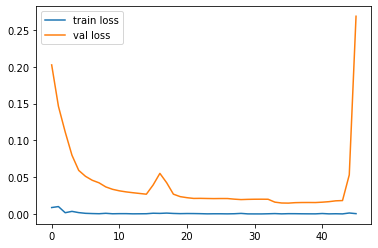

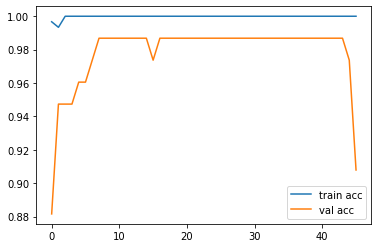

In [ ]:
# loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
# plt.savefig('LossVal_loss')

# accuracies
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
# plt.savefig('AccVal_acc')


In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
loaded_model = load_model('best_model_mobilenew_v2.h5')

In [ ]:
class_name = {'1':'Close', '2': 'Open', '3': 'Unknown'}

In [ ]:
#prediction
#prediction
import numpy as np
import glob
paths = glob.glob('/content/drive/My Drive/ball_valve/*/*.*')
# print(paths)
import cv2
# img_pred = image.load_img(path, target_size=(150, 150))
# img_pred = image.img_to_array(img_pred)
# img_pred = np.expand_dims(img_pred, axis=0)
#images = np.vstack([img_pred])
for path in paths:
    image = cv2.imread(path)
    image = cv2.resize(image, (224, 224))
    image = image/255
    rslt = loaded_model.predict(np.array([image]))
    print(rslt)
#     print(np.argmax(rslt))
    print(path)
    print(class_name[str(np.argmax(rslt)+1)])

[[9.9850452e-01 1.3782441e-05 1.4817105e-03]]
/content/drive/My Drive/ball_valve/close/close_0.png
Close
[[9.9986148e-01 1.4808509e-06 1.3705392e-04]]
/content/drive/My Drive/ball_valve/close/close_1.png
Close
[[9.9970442e-01 1.5567720e-06 2.9405285e-04]]
/content/drive/My Drive/ball_valve/close/close_2.png
Close
[[9.9996328e-01 2.5611667e-05 1.1102778e-05]]
/content/drive/My Drive/ball_valve/close/close_3.png
Close
[[9.9996245e-01 1.1282006e-06 3.6507558e-05]]
/content/drive/My Drive/ball_valve/close/close_5.png
Close
[[9.5016265e-01 6.8267436e-05 4.9769022e-02]]
/content/drive/My Drive/ball_valve/close/close_4.png
Close
[[9.99881864e-01 1.88393506e-06 1.16156894e-04]]
/content/drive/My Drive/ball_valve/close/close_6.png
Close
[[9.999033e-01 7.343186e-08 9.651052e-05]]
/content/drive/My Drive/ball_valve/close/close_7.png
Close
[[9.9425668e-01 1.3635538e-05 5.7297261e-03]]
/content/drive/My Drive/ball_valve/close/close_8.png
Close
[[9.9998832e-01 8.5274305e-06 3.0516085e-06]]
/content/

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
loaded_model = load_model('best_model_mobilenew_v2.h5')

<IPython.core.display.Javascript object>

Saved to photo.jpg
[[9.9964106e-01 3.3850828e-04 2.0418662e-05]]
/content/drive/My Drive/ball_valve/open/webcam_8.png
Close


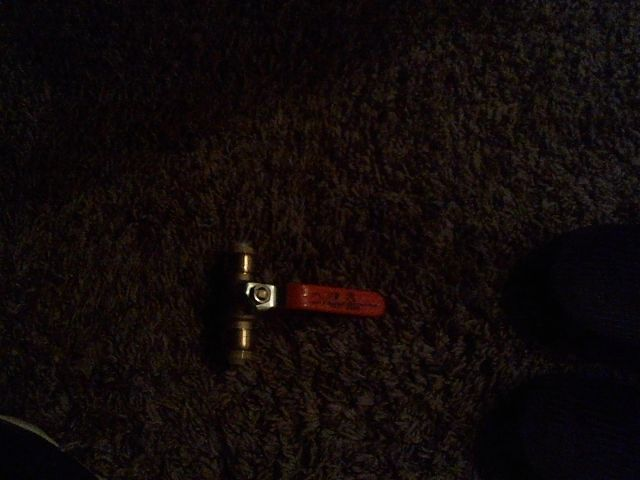

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  image = cv2.imread(filename)
  image = cv2.resize(image, (224, 224))
  image = image/255
  rslt = loaded_model.predict(np.array([image]))
  print(rslt)
  print(path)
  print(class_name[str(np.argmax(rslt)+1)])
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [1]:
  !pip install tensorflowjs[wizard]

     |████████████████████████████████| 71kB 5.8MB/s 
     |████████████████████████████████| 112kB 10.4MB/s 
     |████████████████████████████████| 256kB 13.0MB/s 
  Created wheel for PyInquirer: filename=PyInquirer-1.0.3-cp36-none-any.whl size=32852 sha256=fd3275bcb68e2d4d0b5a353c0eb910f5676f725991ea4fc5dfc8d28d12ffd970
  Stored in directory: /root/.cache/pip/wheels/52/6c/b1/3e4b0e8daf42a92883c7641c0ea8ffb62e0490ebed2faa55ad
Successfully built PyInquirer
  Found existing installation: tensorflow-hub 0.10.0
    Uninstalling tensorflow-hub-0.10.0:
      Successfully uninstalled tensorflow-hub-0.10.0
  Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      Successfully uninstalled prompt-toolkit-1.0.18


In [2]:
!tensorflowjs_wizard

2020-11-25 18:59:32.385678: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Welcome to TensorFlow.js Converter.
l
l
w
_v2.h5
e
 ❯ Keras (HDF5) *
   Tensorflow Keras Saved Model
   Tensorflow Saved Model
   TFHub Module

? What is your output format?  (Use arrow keys)
 ❯ Tensorflow.js Graph Model
   TensoFlow.js Layers Model? What is your output format?  Tensorflow.js Graph Model
 
 ❯ No compression (Higher accuracy)
   float16 quantization (2x smaller, Minimal accuracy loss)
   uint16 affine quantization (2x smaller, Accuracy loss)

? Please enter shard size (in bytes) of the weight files?  4194304? Please enter shard size (in bytes) of the weight files?  4194304
? Which directory do you want to save the converted model in?  ? Which directory do you want to save the converted model in?  models
converter command generated:
tensorflowjs_converter --input_format=keras --output_format=tfjs_graph_model --weight_shard_size

In [4]:
!tensorflowjs_converter --input_format=keras best_model_mobilenew_v2.h5 my_tfjs_model

2020-11-25 19:03:21.694569: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


In [7]:
!zip my_tfjs_model.zip my_tfjs_model/*

  adding: my_tfjs_model/group1-shard1of3.bin (deflated 7%)
  adding: my_tfjs_model/group1-shard2of3.bin (deflated 7%)
  adding: my_tfjs_model/group1-shard3of3.bin (deflated 7%)
  adding: my_tfjs_model/model.json (deflated 96%)
